In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import seaborn as sns
import warnings
import json

# !pip install folium
import folium

warnings.filterwarnings("ignore")

# !pip install googlemaps
import googlemaps

gmaps_key = "-"
gmaps = googlemaps.Client(key=gmaps_key)

from sklearn import preprocessing

%matplotlib inline

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

<br>
<br>

# 데이터 준비
## 서울시 범죄 현황 csv

In [2]:
crime_anal_police = pd.read_csv('./02. crime_in_Seoul.csv', thousands=',', encoding='euc-kr')
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


<br>

## 경찰서의 주소와 위/경도 알아내기
위의 데이터를 보면 경찰서의 이름이 00서 로 되어있음을 알 수 있습니다. 따라서 이를 서울00경찰서로 만드는 과정이 필요합니다.
이를 위해 관서명 앞에 `서울` 을 붙이고, 관서명의 `서` 부분을 제거하고 `경찰서` 를 붙이는 작업을 수행 해야 합니다.

In [3]:
station_name = []

for name in crime_anal_police['관서명']:
    station_name.append('서울' + str(name[:-1]) + '경찰서')

station_name[:5]

['서울중부경찰서', '서울종로경찰서', '서울남대문경찰서', '서울서대문경찰서', '서울혜화경찰서']

In [ ]:
경찰서 이름을 알아냈으니, 이를 토대로 구글 맵에서 경찰서의 주소를 받아옵니다.

In [4]:
station_address = []
station_lat = []  # 위도
station_lng = []  # 경도

for name in station_name:
    tmp = gmaps.geocode(name, language='ko')
    
    if tmp:
        station_address.append(tmp[0].get("formatted_address"))
        tmp_loc = tmp[0].get("geometry")
        station_lat.append(tmp_loc['location']['lat'])
        station_lng.append(tmp_loc['location']['lng'])
        print(name + '-->' + tmp[0].get("formatted_address"))
    else:
        print("No geocode result found for:", name)


서울중부경찰서-->대한민국 서울특별시 중구 수표로 27
서울종로경찰서-->대한민국 서울특별시 종로구 인사동5길 41
서울남대문경찰서-->대한민국 서울특별시 중구 한강대로 410
서울서대문경찰서-->대한민국 서울특별시 서대문구 통일로 113
서울혜화경찰서-->대한민국 서울특별시 종로구 창경궁로 112-16
서울용산경찰서-->대한민국 서울특별시 용산구 백범로 329
서울성북경찰서-->대한민국 서울특별시 성북구
서울동대문경찰서-->대한민국 서울특별시 동대문구 약령시로21길 29
서울마포경찰서-->대한민국 서울특별시 마포구 마포대로 183
서울영등포경찰서-->대한민국 서울특별시 영등포구 국회대로 608
서울성동경찰서-->대한민국 서울특별시 성동구 왕십리광장로 9
No geocode result found for: 서울동작경찰서
서울광진경찰서-->대한민국 서울특별시 광진구 자양로 167
서울서부경찰서-->대한민국 서울특별시 은평구 진흥로 58
서울강북경찰서-->대한민국 서울특별시 강북구 오패산로 406
서울금천경찰서-->대한민국 서울특별시 금천구 시흥대로73길 50
서울중랑경찰서-->대한민국 서울특별시 중랑구 묵제2동 249-2
서울강남경찰서-->대한민국 서울특별시 강남구 테헤란로114길 11
서울관악경찰서-->대한민국 서울특별시 관악구 관악로5길 33
서울강서경찰서-->대한민국 서울특별시 강서구 화곡로 308
서울강동경찰서-->대한민국 서울특별시 강동구 성내로 57
서울종암경찰서-->대한민국 서울특별시 성북구 화랑로7길 32
서울구로경찰서-->대한민국 서울특별시 구로구 새말로 97 신도림테크노마트 5층
서울서초경찰서-->대한민국 서울특별시 서초구 반포대로 179
서울양천경찰서-->대한민국 서울특별시 양천구 목동동로 99
서울송파경찰서-->대한민국 서울특별시 송파구 중대로 221
서울노원경찰서-->대한민국 서울특별시 노원구 노원로 283
서울방배경찰서-->대한민국 서울특별시 서초구 동작대로 204
서울은평경찰서-->대한민국 서울특별시 은평구 연서로 365
서울도봉경찰서

googlemaps 에서 서울동작경찰서의 주소를 제대로 받아오지 못하기 때문에 이는 직접 넣어 수정해주어야 합니다.
_예외로 따로 빼내 수정하였으며, 정보는 구글에서 검색한 내용을 토대로 가져왔습니다._

In [5]:
station_address = []
station_lat = []  # 위도
station_lng = []  # 경도

for name in station_name:
    tmp = gmaps.geocode(name, language='ko')
    
    if tmp:
        station_address.append(tmp[0].get("formatted_address"))
        tmp_loc = tmp[0].get("geometry")
        station_lat.append(tmp_loc['location']['lat'])
        station_lng.append(tmp_loc['location']['lng'])
    elif name == '서울동작경찰서':
        station_address.append("대한민국 서울특별시 동작구 노량진로 148")
        station_lat.append(37.5131)
        station_lng.append(126.9428)
    else:
        print("No geocode result found for:", name)

station_address[:5]

['대한민국 서울특별시 중구 수표로 27',
 '대한민국 서울특별시 종로구 인사동5길 41',
 '대한민국 서울특별시 중구 한강대로 410',
 '대한민국 서울특별시 서대문구 통일로 113',
 '대한민국 서울특별시 종로구 창경궁로 112-16']

In [6]:
station_lat[:5]

[37.56361709999999, 37.571824, 37.5547584, 37.5647439, 37.5719679]

In [7]:
station_lng[:5]

[126.9896517, 126.9841533, 126.9734981, 126.9667705, 126.9989574]

<br>

## 구한 주소를 토대로 구별로 분류하기

In [8]:
gu_name = []

station_address
for name in station_address:
    tmp = name.split()
    tmp_gu = [gu for gu in tmp if gu[-1] == '구'][0]
    gu_name.append(tmp_gu)
    
crime_anal_police['구별'] = gu_name
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


구별로 정리 하고 나면, 같은 구가 한번 이상 나타나는 경우가 생깁니다. 이를 보기 좋게 다시 데이터를 구별로 정리해야 합니다.

In [9]:
## 구별 컬럼을 새로 만들었기 때문에 이를 따로 저장 해줍니다.
crime_anal_police.to_csv('./02. crime_in_Seoul_include_gu_name.csv',
                        sep=',',
                        encoding='utf=8')

crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


In [10]:
crime_anal_raw = pd.read_csv('./02. crime_in_Seoul_include_gu_name.csv', 
                             encoding='utf-8', 
                             index_col=0)

# 관서명 컬럼 제거하기
crime_anal_raw.drop('관서명', axis=1, inplace=True)

crime_anal = pd.pivot_table(crime_anal_raw,
                           index='구별',
                           aggfunc=np.sum)
crime_anal.head()

,강간 검거,강간 발생,강도 검거,강도 발생,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생
구별,,,,,,,,,,
강남구,349,449,18,21,10,13,1650,3850,3705,4284
강동구,123,156,8,6,3,4,789,2366,2248,2712
강북구,126,153,13,14,8,7,618,1434,2348,2649
강서구,191,262,13,13,8,7,1260,2096,2718,3207
관악구,221,320,14,12,8,9,827,2706,2642,3298


<br>

## 범죄와 검거 데이터를 이용하여 검거율 구하기

In [11]:
crime_anal['강간 검거율'] = crime_anal['강간 검거']/crime_anal['강간 발생']*100
crime_anal['강도 검거율'] = crime_anal['강도 검거']/crime_anal['강도 발생']*100
crime_anal['살인 검거율'] = crime_anal['살인 검거']/crime_anal['살인 발생']*100
crime_anal['절도 검거율'] = crime_anal['절도 검거']/crime_anal['절도 발생']*100
crime_anal['폭력 검거율'] = crime_anal['폭력 검거']/crime_anal['폭력 발생']*100

del crime_anal['강간 검거']
del crime_anal['강도 검거']
del crime_anal['살인 검거']
del crime_anal['절도 검거']
del crime_anal['폭력 검거']

crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간 검거율,강도 검거율,살인 검거율,절도 검거율,폭력 검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,114.285714,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157


검거율을 보면 100 이 넘는 수치가 존재합니다. 이는 전년도 발생 건수에 대한 검거도 포함이기에 일단 100 으로 처리합니다.

In [12]:
con_list = ['강간 검거율', '강도 검거율', '살인 검거율', '절도 검거율', '폭력 검거율']

for column in con_list:
    crime_anal.loc[crime_anal[column] > 100, column] = 100

crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간 검거율,강도 검거율,살인 검거율,절도 검거율,폭력 검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157


In [13]:
crime_anal.rename(columns = {'강간 발생':'강간',
                            '강도 발생':'강도',
                            '살인 발생':'살인',
                            '절도 발생':'절도',
                            '폭력 발생':'폭력'}, 
                  inplace=True)

crime_anal.head()

,강간,강도,살인,절도,폭력,강간 검거율,강도 검거율,살인 검거율,절도 검거율,폭력 검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157


<br>

## 데이터 정규화 하기
각 범죄의 발생 회수를 다시한번 들여다 봅시다. 어떤 범죄는 한자리수인 반면, 어떤 범죄는 4자리수 입니다.
때문에 최대수치를 1로 두고 정규화를 하면 나중에 종합적으로 데이터를 비교할때 편리할 것입니다.
이번에는 `scikit learn` 에 있는 전처리 도구에 있는, 최소값, 최대값을 이용해 데이터를 정규화 하는 함수를 사용하겠습니다.

In [14]:
col = ['강간', '강도', '살인', '절도', '폭력']

x = crime_anal[col].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
crime_anal_norm = pd.DataFrame(x_scaled, columns = col, index = crime_anal.index)

col2 = ['강간 검거율', '강도 검거율', '살인 검거율', '절도 검거율', '폭력 검거율']
crime_anal_norm[col2] = crime_anal[col2]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간 검거율,강도 검거율,살인 검거율,절도 검거율,폭력 검거율
구별,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157


<br>

## 서울시 구별 CCTV 개수 데이터와 합치기

In [15]:
result_CCTV = pd.read_csv('./01. CCTV_result.csv',
                         encoding='UTF-8',
                         index_col='구별')

crime_anal_norm[['인구수', 'CCTV']] = result_CCTV[['인구수', '소계']]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간 검거율,강도 검거율,살인 검거율,절도 검거율,폭력 검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772.0,884
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496


<br>

## 각 범죄 합과 검거 합 구하기

In [16]:
col = ['강간', '강도', '살인', '절도', '폭력']
crime_anal_norm['범죄'] = np.sum(crime_anal_norm[col], axis=1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간 검거율,강도 검거율,살인 검거율,절도 검거율,폭력 검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.857843
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.286607
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.641616
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772.0,884,2.333944
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.860342


In [17]:
col = ['강간 검거율', '강도 검거율', '살인 검거율', '절도 검거율', '폭력 검거율']
crime_anal_norm['검거'] = np.sum(crime_anal_norm[col], axis=1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간 검거율,강도 검거율,살인 검거율,절도 검거율,폭력 검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.857843,369.707384
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.286607,370.084431
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.641616,406.943540
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772.0,884,2.333944,417.767372
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.860342,368.622261


<br>
<br>

# 데이터 시각화
## 인구수, CCTV 개수 와 범죄 데이터의 상관관계 알아보기

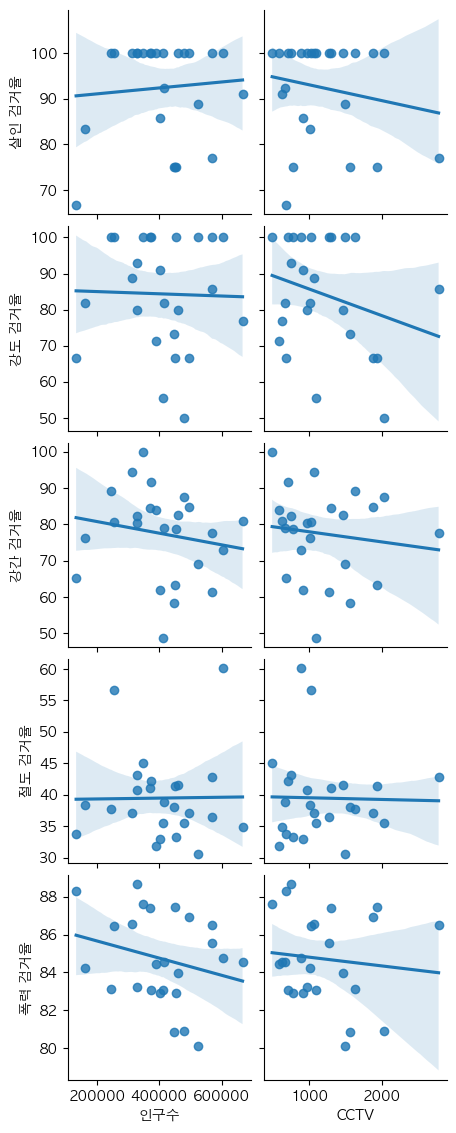

In [18]:
sns.pairplot(crime_anal_norm, x_vars=["인구수", "CCTV"],
             y_vars=["살인 검거율", "강도 검거율", "강간 검거율", "절도 검거율", "폭력 검거율"],
             kind='reg', 
             height=2.3)
plt.show()

그래프의 회귀선의 기울기가 음수라는 것은 변수가 증가함에 따라 검거율이 감소하는 경향이 있다는 것을 의미합니다. 즉, 결과 그래프는 인구수나 CCTV 수가 많을수록 검거율이 낮아진다는 추세를 보여주고 있습니다. 
하지만, **이러한 관계가 반드시 인과 관계를 의미하는 것은 아닙니다.** 다른 숨겨진 변수들이나 다양한 요인들이 이러한 관계에 영향을 줄 수 있습니다.

회귀선 주변의 음영 처리된 영역은 추정된 회귀선의 불확실성을 나타내는 신뢰 구간을 의미합니다. 이 구간이 넓으면 넓을수록 예측의 불확실성이 크다는 것을 의미합니다.
따라서 이 데이터만으로는 CCTV의 수와 인구수가 검거율에 부정적인 영향을 미친다고 단정 지을 수 없습니다.

<br>

## heatmap 으로 범죄 검거 비율과 범죄 비율 시각화

In [19]:
# 검거 항목 최고값을 100 으로 한정하고(정규화) 그 값으로 정렬합니다.
tmp_max = crime_anal_norm['검거'].max()

crime_anal_norm['검거'] = crime_anal_norm['검거'] / tmp_max * 100
crime_anal_norm_sort = crime_anal_norm.sort_values(by='검거', ascending=False)
crime_anal_norm_sort.head()

,강간,강도,살인,절도,폭력,강간 검거율,강도 검거율,살인 검거율,절도 검거율,폭력 검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.0,100.0,44.967074,87.626093,348646.0,485,0.318627,100.000000
금천구,0.141210,0.058824,0.083333,0.180840,0.202717,80.794702,100.0,100.0,56.668794,86.465433,255082.0,1015,0.666924,97.997139
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.0,100.0,60.114504,84.752105,603772.0,884,2.333944,96.572809
광진구,0.397695,0.529412,0.166667,0.704342,0.406864,91.666667,100.0,100.0,42.200925,83.047619,372164.0,707,2.204979,96.375820
동대문구,0.204611,0.470588,0.250000,0.329386,0.379335,84.393064,100.0,100.0,41.090358,87.401884,369496.0,1294,1.633921,95.444250


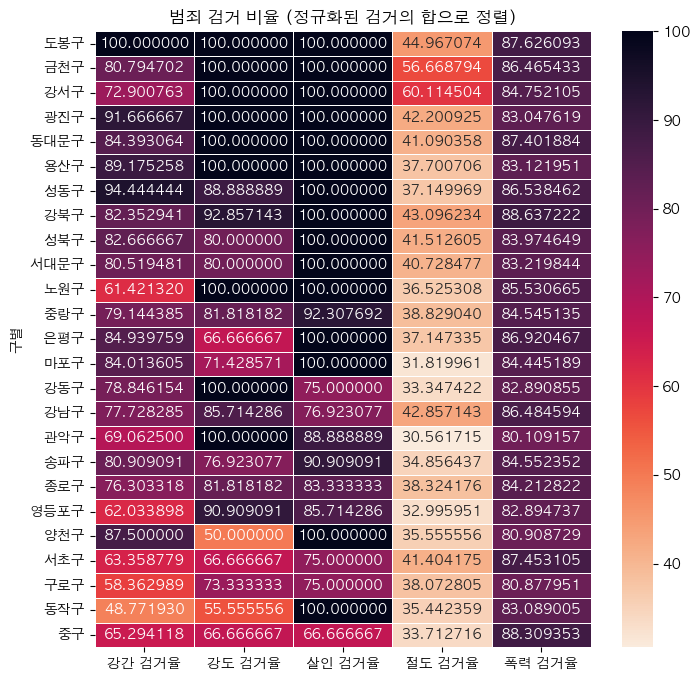

In [20]:
target_col = ['강간 검거율', '강도 검거율', '살인 검거율', '절도 검거율', '폭력 검거율']

crime_anal_norm_sort = crime_anal_norm.sort_values(by='검거', ascending=False)

plt.figure(figsize = (8,8))
sns.heatmap(crime_anal_norm_sort[target_col], 
            annot=True, 
            fmt='f', 
            cmap='rocket_r',  # 색상 뒤집기
            linewidths=.5)
plt.title('범죄 검거 비율 (정규화된 검거의 합으로 정렬)')
plt.show()

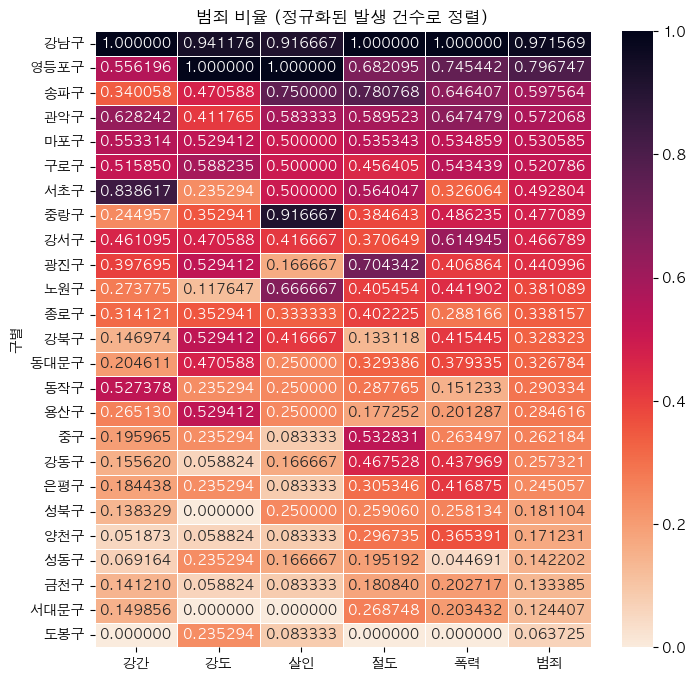

In [21]:
target_col = ['강간', '강도', '살인', '절도', '폭력', '범죄']

crime_anal_norm['범죄'] = crime_anal_norm['범죄'] / 5  # 정규화
crime_anal_norm_sort = crime_anal_norm.sort_values(by='범죄', ascending=False)

plt.figure(figsize = (8,8))
sns.heatmap(crime_anal_norm_sort[target_col], 
            annot=True, 
            fmt='f', 
            cmap='rocket_r',  # 색상 뒤집기
            linewidths=.5)
plt.title('범죄 비율 (정규화된 발생 건수로 정렬)')
plt.show()

<br>

## Folium 을 사용한 서울시 범죄합에 대한 지도 시각화
### 범죄 발생 건수 시각화

In [22]:
geo_path = './02. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [23]:
map = folium.Map(location=[37.5502, 126.982], 
                 zoom_start=11,
                 tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_str,
    data=crime_anal_norm['범죄'],
    columns=[crime_anal_norm.index, crime_anal_norm['범죄']],
    fill_color='PuRd',
    key_on='feature.id'
).add_to(map)

map

### 검거 건수 시각화

In [24]:
map = folium.Map(location=[37.5502, 126.982], 
                 zoom_start=11,
                 tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_str,
    data=crime_anal_norm['검거'],
    columns=[crime_anal_norm.index, crime_anal_norm['검거']],
    fill_color='PuRd',
    key_on='feature.id'
).add_to(map)

map

<br>

## 서울시 경찰서별 검거율과 구별 범죄합 시각화

In [25]:
crime_anal_raw['lat'] = station_lat
crime_anal_raw['lng'] = station_lng

col = ['살인 검거', '강도 검거', '강간 검거', '절도 검거', '폭력 검거']
tmp = crime_anal_raw[col] / crime_anal_raw[col].max()

crime_anal_raw['검거'] = np.sum(tmp, axis=1)

crime_anal_raw.head()

,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563617,126.989652,1.275416
1,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.571824,126.984153,1.523847
2,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564744,126.966770,1.978299
4,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571968,126.998957,1.198382


In [26]:
def draw_crime_map(geo_str, crime_data, raw_data):
    # 지도 객체 생성
    map = folium.Map(location=[37.5502, 126.982], zoom_start=11)
    
    # 코로플레스 레이어 추가
    folium.Choropleth(
        geo_data=geo_str,
        data=crime_data['범죄'],
        columns=[crime_data.index, crime_data['범죄']],
        fill_color='PuRd',
        key_on='feature.id'
    ).add_to(map)
    
    # 원형 마커 레이어 추가
    for n in raw_data.index:
        folium.CircleMarker(
            [raw_data['lat'][n], raw_data['lng'][n]],
            radius=raw_data['검거'][n] * 10,
            color='#3186cc',
            fill_color='#3186cc',
            fill=True
        ).add_to(map)
    
    return map

map = draw_crime_map(geo_str, crime_anal_norm, crime_anal_raw)
map

In [ ]:
<br>
<br>

# 데이터 해석

In [27]:
map

구현한 결과 그래프 입니다. 그래프에서 범죄가 많이 일어나는 지역일 수록 붉게 표시되고, 경찰서의 검거율이 높을 수록 원의 모양이 큽니다.
- 서울 서부의 경우 범죄가 빈번하게 발생하지만 그만큼 검거율이 높습니다.
- 서울 강북의 중앙부는 검거율이 낮지만 그만큼 범죄 발생수도 적습니다.